# Segmenting interlayers

* [Problem description](#description)
* [Dataset](#dataset)
* [Model architecture](#architecture)
* [Training](#training)
* [Validation](#validation)
* [Criticism](#criticism)
* [Conclusion](#conclusion)
* [Suggestions for improvements](#suggestions)

<a id='description'></a>

# Problem description
Welcome! In this notebook we train a neural network for multiclass-segmentation of *seismic interlayers*. Seismic interlayer is a layer of earth formation between two horizons, labeled by a geophysicist. In a way, a set of several horizons yields coloring of a seismic cube in different interlayers:

<img src="images/facies.png" alt="Drawing" style="width: 600px;"/>

Each seismic interlayer is thought to have roughly similar seismic reflection parameters across all of its volume. Naturally, convolutional neural networks should be able to learn patterns of a specific interlayer. As a result models, trained on a small subset of *ilines/xlines* of a seismic cube are expected to classify interlayers on unseen (during training) parts of seismic cubes with reasonable accuracy.

In [174]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
sys.path.append('../repos/seismiqb/')
from seismiqb import SeismicCropBatch, SeismicCubeset, make_labels_dict, read_point_cloud, plot_loss, plot_batch_components
from seismiqb.batchflow import FilesIndex, D, L, F, Pipeline, B, V, W, C, NumpySampler
from seismiqb.batchflow.models.tf import UNet
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [4]:
%load_ext autoreload
%autoreload 2

<a id='dataset'></a>

# Dataset
We use one seismic cube `P_cube` for training/testing. One can find [here]() a description of cube `P_cube` along with some visualiztions. `P_cube` is a 3d-array of data of shape **[2737, 2599, 2001]** Along with the cube itself come 4 labeled horizons. Check out an `iline`-slice from a cube:

<img src="images/P_cube_slice.png" alt="Drawing" style="width: 600px;"/>

Importantly, for training and testing we use different sets of *ilines*: 45% of *ilines* are reserved for training while 35% of *ilines* are used for testing (the rest 20% of ilines are used as a margin between training and testing parts to battle overfit). Due to the fact that full-sized cube cannot be fit into GPU-memory, we train our model on crops of size **[128, 128, 1]**.

In the next cells we set up a structure for storing information about our seismic cube `P_cube`

In [5]:
DATA_DIR = '/notebooks/SEISMIC_DATA/CUBE_3/'
qbix = FilesIndex(path=os.path.join(DATA_DIR, 'P_cube.hdf5'), no_ext=True)
qbset = SeismicCubeset(qbix)

We can now fill up the structure by loading horizon-labels into it

In [6]:
qbset.load()

Again, we are going to train our model on crops on `P_cube` of size **[128, 128, 1]**. Clearly, it is important to sample crop-locations in a correct way. Our strategy goes as follows: sample approximately half of crops from the position of horizon-labels, and the other half from uniform distribution over the cube. In that way, the model will
* have a great look on places where one interlayer changes for another and 
* be able to learn to correctly classify crops of one interlayer.

In the next cell we specify a `Sampler`-attribute of a `qbset` that samples crop-positions in the described way. Note also the use of upper bound of **45%** on sampled *ilines* (that is, we won't use *ilines*  with number higher than `1231 = 0.45 * 2737`).

In [104]:
qbset.modify_sampler(dst='train_1', high=0.45, finish=False)
qbset.train_mix = qbset.train_1 | (qbset.train_1.apply(lambda x: x[:, :3])
                                   & NS('u', low=0.05, high=0.8))
qbset.train_mix_ = qbset.train_mix.sample

We can now make a test-sampler. In doing so, we introduce a lower bound of **65%** on sampled *ilines*:

In [ ]:
qbset.modify_sampler(dst='test_sample', low=0.6, finish=True)

Before performing any real computation we need a *plan*. For that purposes `Batchflow` uses `Pipeline` - a sequence of actions performed on data. In the next cell we set up a plan (again, we do not compute anything here!) for sampling and loading crops (action `load_cubes`) and creating target-masks (action `create_masks`): 

In [106]:
train_config = {'sample': 'train_mix_'}
preprocessing = (Pipeline(config=train_config)
                 .load_component([D('labels'), D('geometries')],
                                 ['labels', 'geometries'])
                 .crop(points=L(D(C('sample')))(size=26),
                       shape=(1, 128, 128),
                       passdown=['geometries', 'labels'])
                 .load_cubes(dst='cubes')
                 .create_masks(dst='masks', mode='stratum')
                 .rotate_axes(src=['masks', 'cubes'])
                 .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks'))

<a id='architecture'></a>

# Model architecture
We use a convolutional neural network [`U-net`](https://arxiv.org/abs/1505.04597) for interlayers segmentation.

The first step is to configure `unet` for working with our data using configuration dictionary. Note the specification of
* input crop-shape **[128, 128]**
* **6** input-classes: 5 interlayers between 4 horizons + missing-label class
* **6** model-output classes to predict the probability of each class

In [109]:
model_config = {'inputs/cubes/shape' : (128, 128, 1),
                'inputs/masks/name': 'targets',
                'inputs/masks/shape': (128, 128),
                'inputs/masks/classes': 6,
                'inputs/masks/transform': 'ohe',
                'initial_block/inputs': 'cubes',
                'loss': 'dice',
                'head/num_classes': 6,
                'optimizer': 'Adam'}

<a id='training'></a>

# Training
We can go on with training of the model. `U-net` is trained of 2d-crops of seismic cubes of size `[128, 128]`. The training-procedure uses `Adam`-optimizer and is performed on batches of 26 crops.

To begin with, we add a couple of actions to our preprocessing `pipeline` (with `train_model` being the most important):

In [111]:
training = (preprocessing +
             Pipeline()
             .init_variable('loss', init_on_each_run=list)
             .init_variable('current_loss')
             .init_model('static', UNet, 'model', model_config)
             .train_model('model', cubes=B('cubes'), masks=B('masks'),
                          fetches='loss', save_to=V('current_loss'))
             .update_variable('loss', V('current_loss'), mode='a'))

we then associate a dataset containing cube `P_cube` with our training-plan:

In [112]:
training_ds = (qbset >> training)

and run the training procedure:

In [132]:
N_ITERS = 600
tr = trange(N_ITERS, leave=True)
for i in tr:
    training_ds.next_batch(1, n_epochs=None)
    tr.set_description("current loss is {}".format(training_ds.v('current_loss')))
    clear_output()


current loss is -0.0472383089363575: 100%|██████████| 300/300 [12:56<00:00,  2.71s/it]

After just 600 iterations training loss starts to go on a plateau:

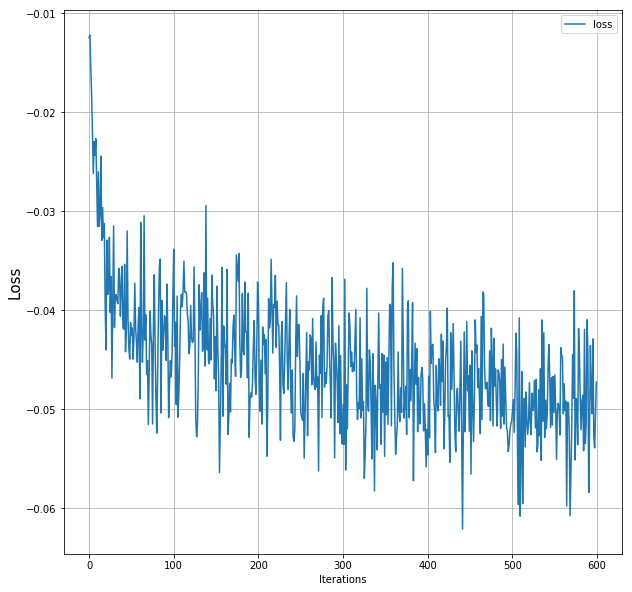

In [173]:
plot_loss(training_ds.v('loss'), ['loss'])

It might me a good time to save the model!

In [194]:
MODEL_PATH = "/notebooks/koryagin/saved_models/cube_p"
training_ds.save_model_now('model', path=MODEL_PATH)

# Validation

In this section we look at predictions of our model on *ilines* of the cube we haven't used for training. Validation comes in two parts:
* First of all, we check out predictions of our model on *crops* from test-part of the cube 
* Secondly, we check out the predictions of the model on *full* *ilines* from test-part of `P_cube`

Let's first look at the predictions on crops.

## 1. Validation on crops from test-part of `P_cube`

The first step is to reconfigure preprocessing `pipeline`, so that it would sample crops from a test-part of the cube using `test_sampler`:

In [139]:
preprocessing.set_config({'sample': 'test_sample'})
testbatch = (qbset >> preprocessing.next_batch(1)
targets, predictions = model.predict(fetches=['targets', 'predictions'],
                                     cubes=testbatch.cubes, masks=testbatch.masks)

let's check out the crops

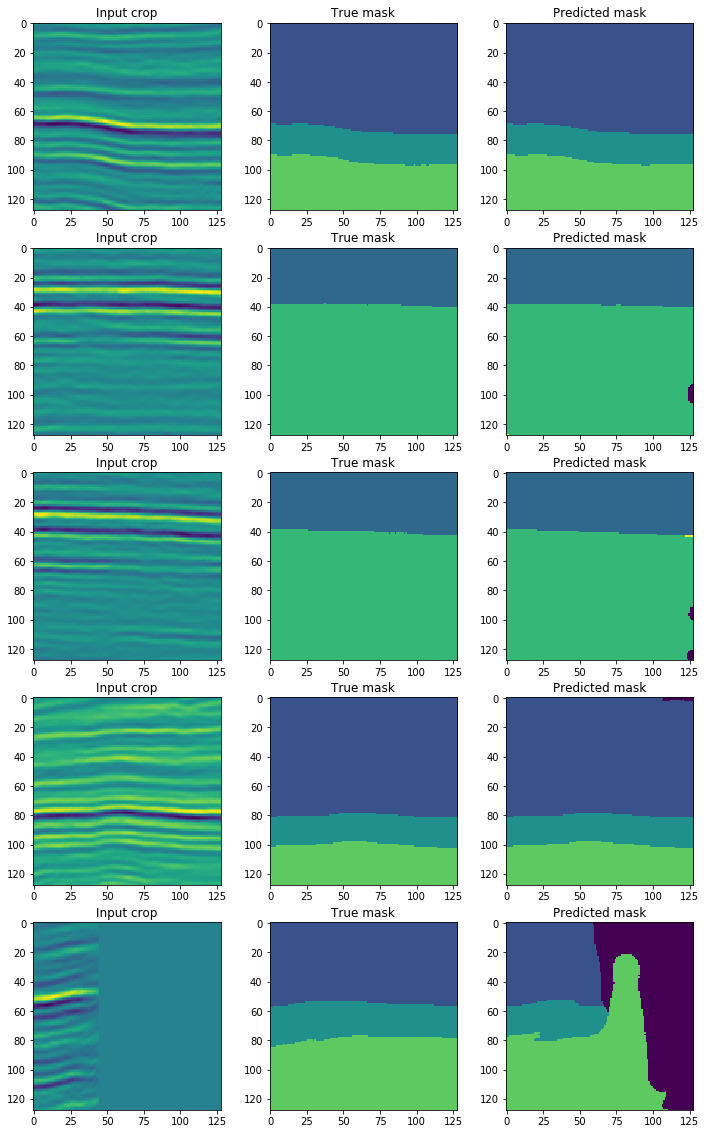

In [222]:
plot_stratum_predictions(testbatch.cubes, targets, predictions, 5)

As you can see, the predictions on crops from locations of horizon-labels are of reasonable quality. Rare mistakes are usually related to the missing labels.

Importantly, we sampled crops *only* from locations of horizon-labels. Let's find out what will happen if we sample crops from parts of the cube where interlayers do not change.

In [227]:
qbset.modify_sampler(dst='test_2', low=0.6, finish=False)
qbset.test_mix = qbset.test_2.apply(lambda x: x[:, :3]) & NS('u', low=0.05, high=0.8)
qbset.test_mix_ = qbset.test_mix.sample

In [228]:
preprocessing.set_config({'sample': 'test_mix_'})
testbatch = (qbset >> preprocessing).next_batch(1)
targets, predictions = model.predict(fetches=['targets', 'predictions'],
                                     cubes=testbatch.cubes, masks=testbatch.masks)

let's look at the crops

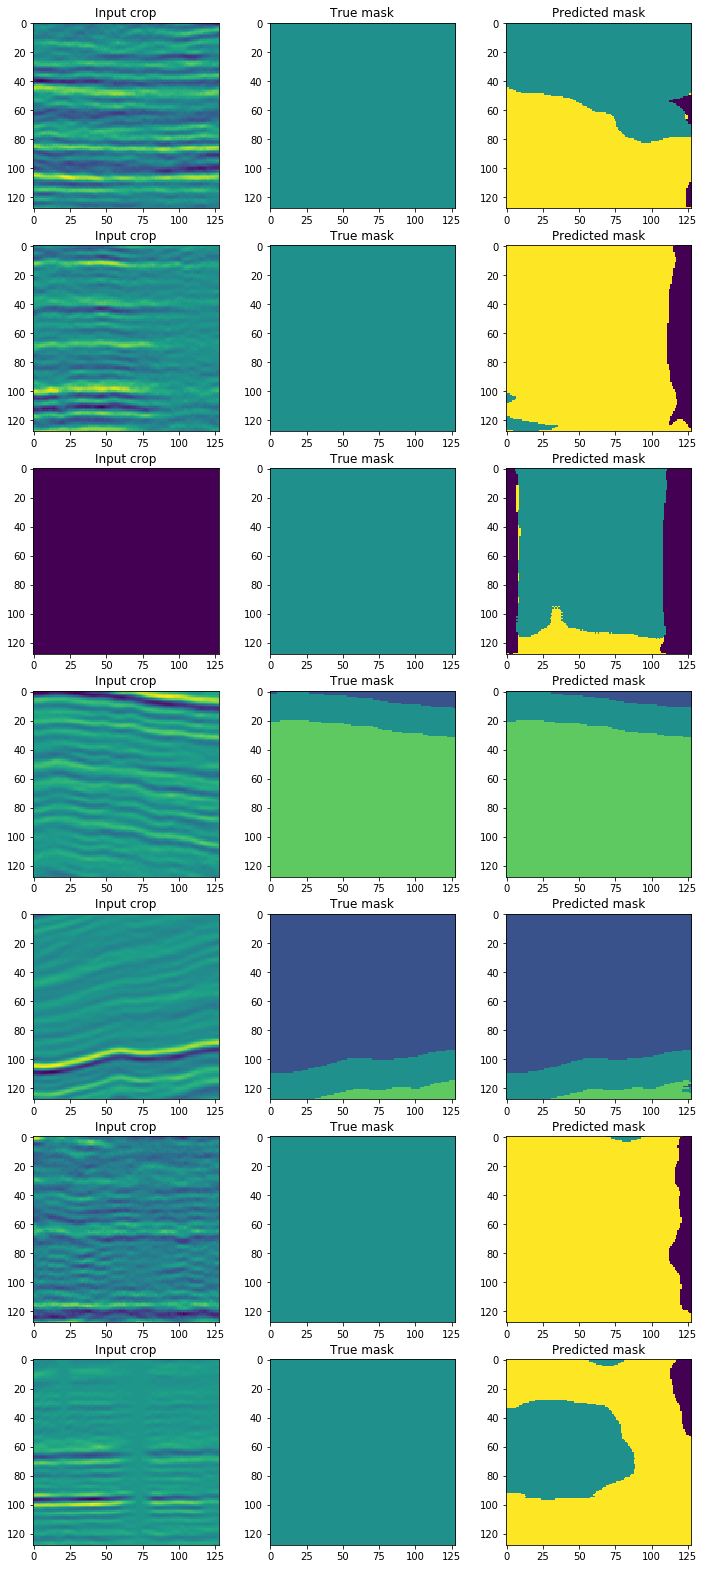

In [230]:
plot_stratum_predictions(testbatch.cubes, targets, predictions, 7)

As we can see, the quality of the model drops substantially as the model misclasifies crops without a change in interlayers.

## 2. Validation on full test-*ilines*

Lastly, we can look at the predictions obtained on the full-slice. This will allow to quickly grasp how the model is performing.

To form the prediction on a full *iline*, we need to split the slice in crops and set up an iterating procedure along the resulting list of crops. We can do that using `make_grid`-function:

In [176]:
qbset.make_grid('P_cube', (1, 128, 128),        # choosing cube and crop shape
                [2000, 2001], [50, 2050], [30, 1500])  # range representing an iline

Assemble the test-`pipeline`. Note the use of function `assemble_crops` in the end that assembles prediction-crops in a full *iline*.

In [178]:
test = (Pipeline()
        # preprocessing
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('grid_gen')),
               shape=(1, 128, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .rotate_axes(src=['masks', 'cubes'])
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .import_model('model', training_ds)
         # fetching model-predictions
         .init_variables({'cubes': {'init_on_each_run': list()}, 'masks': {'init_on_each_run': list()},
                          'predictions': {'init_on_each_run': list()},
                          'predictions_amax': {'init_on_each_run': list()},
                          'masks_3d': {'init_on_each_run': list()}})
         .predict_model('model',
                        fetches=['cubes', 'masks', 'predictions'],
                        cubes=B('cubes'), masks=B('masks'),
                        save_to=[V('cubes', mode='e'), V('masks', mode='e'), V('predictions', mode='e')])
         .update_variable('predictions_amax',
                          L(lambda lst: [targets.argmax(axis=-1)[..., np.newaxis] for targets in lst])
                            (V('predictions')))
         .update_variable('masks_3d', L(lambda lst: [targets[..., np.newaxis] for targets in lst])
                                        (V('masks')))
         # assembling crops into full-sized ilines
         .assemble_crops(src=V('cubes'), dst='assembled_cube',
                         grid_info=D('grid_info'))
         .assemble_crops(src=V('predictions_amax'), dst='assembled_pred',
                         grid_info=D('grid_info'))
         .assemble_crops(src=V('masks_3d'), dst='assembled_mask',
                         grid_info=D('grid_info')))

Run the pipeline and check out the results:

In [181]:
test_ds = (qbset >> test)
for _ in tqdm(range(qbset.grid_iters)):
    pred_batch = test_ds.next_batch(1, n_epochs=None)

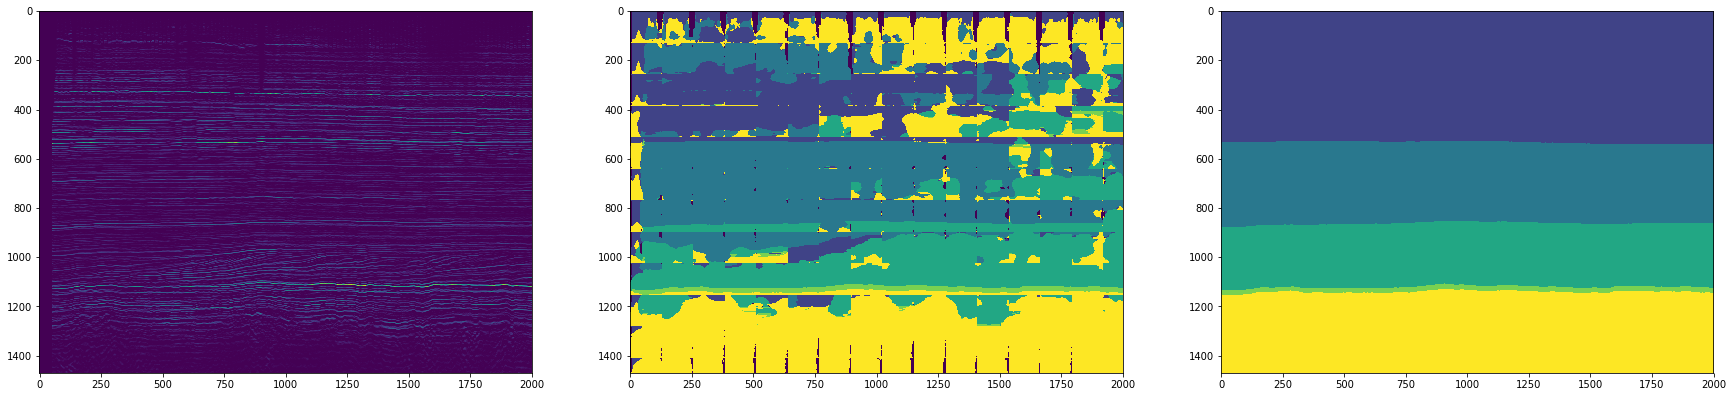

In [231]:
pred_batch.ac, pred_batch.am, pred_batch.ap  = (np.squeeze(pred_batch.assembled_cube), np.squeeze(pred_batch.assembled_mask),
                                                np.squeeze(pred_batch.assembled_pred))
fig, ax = plt.subplots(1, 3, figsize=(30, 70))
ax[0].imshow(pred_batch.ac.T)
ax[1].imshow(pred_batch.ap.T)
ax[2].imshow(pred_batch.am.T)
plt.show()

# Criticism

# Conclusion

All in all, the model performs reasonably well on crops taken from the locations of the horizons but fails to correctly classify crops from locations where interlayers do not change. The most probable explanation goes as follows: the model simply memorizes the horizons. As a result, it works well in horizons' neigbourhood. However, the model does not learn to distinguish different interlayers from one another using reflection    

# Suggestions for improvments